# About NMF

**Non-Negative Matrix Factorization (NMF)** is a dimensionality reduction and topic extraction technique often used in text analysis. Its goal is to take a large matrix (usually a document–term or TF-IDF matrix) and break it into two smaller, easier-to-interpret matrices that reveal hidden structure such as topics.

### Why “Non-Negative”?
- All values in the input matrix and the output matrices must be zero or positive — no negative values are allowed.
- This fits naturally with text data (e.g., word counts cannot be negative).
- Topics become additive combinations of words, making them easier to interpret.

### How NMF Works
You begin with the original document–term matrix **V**.

NMF factorizes **V** into two smaller matrices:

- **W** – indicates how strongly each *document* relates to each topic.
- **H** – indicates how strongly each *word* contributes to each topic.

When multiplied, the smaller matrices approximate the original:

**W × H ≈ V**

### Other Applications of NMF
- Computer vision
- Audio and music processing
- Recommender systems
- Clustering
- Data compression


 # Preprocessing for NMF

- Lowercase
- Remove punctuation + numbers + extra spacing
- Create spaCy Doc - tokenize (tokenization happen inside spaCy automatically) 
- Lemmatise
- Remove stopwords
- Filter by POS (NOUN, PROPN, ADJ)
- Join tokens into cleaned text strings 
- Use TF-IDF matrix
- Remove rare and overly common words 
- Fit NMF model 

[note: I'm not 100% of the correct order as different things are in different places - and the order differs for libraries so may need to come back and check this]

# Load and check data

In [1]:
import pandas as pd
import spacy

from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import NMF

from gensim.models import CoherenceModel
from gensim.corpora import Dictionary 
from gensim.models.nmf import Nmf

import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_style('darkgrid')


# pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv("/workspaces/AM1_topic_modelling/data/short/items_final_themes.csv")

In [3]:
df.head(1)

,id,newsletter_number,issue_date,theme,subtheme,title,description,link,new_theme,domain,organisation,org_broad_category,org_category,title_length,description_length,title_word_count,description_word_count,text,text_length_chars,text_length_words
0,c97ff62f-83ca-47ec-a4c7-b4e24157ae0a,1,11 July 2023,Calls for evidence,NaN,Deadline 23 August 2023,Education secretary Gillian Keegan has launche...,https://schoolsweek.co.uk/chatgpt-keegan-launc...,political_environment_key_organisations,schoolsweek.co.uk,schools_week,media_sector,specialist_media,23,174,4,28,Deadline 23 August 2023 Education secretary Gi...,198,32


In [4]:
df.columns

Index(['id', 'newsletter_number', 'issue_date', 'theme', 'subtheme', 'title',
       'description', 'link', 'new_theme', 'domain', 'organisation',
       'org_broad_category', 'org_category', 'title_length',
       'description_length', 'title_word_count', 'description_word_count',
       'text', 'text_length_chars', 'text_length_words'],
      dtype='object')

In [5]:
# drop unnessecary columns

In [6]:
df = df.drop(['text_length_chars', 'text_length_words', 'title_length',
       'description_length', 'title_word_count', 'description_word_count','theme', 'subtheme', 'title',
       'description'], axis=1)

# Preprocessing with Pandas 

In [7]:
#lowercase
df["text_clean"] = df["text"].str.lower()

In [8]:
df[["text", "text_clean"]].head()

,text,text_clean
0,Deadline 23 August 2023 Education secretary Gi...,deadline 23 august 2023 education secretary gi...
1,Revealed: the experts advising ministers on te...,revealed: the experts advising ministers on te...
2,"Reject fewer teacher applicants, DfE tells tra...","reject fewer teacher applicants, dfe tells tra..."
3,Ofqual and DfE studying 'feasibility' of 'full...,ofqual and dfe studying 'feasibility' of 'full...
4,Revealed: The full details of Labour's educati...,revealed: the full details of labour's educati...


In [9]:
#remove urls 
df["text_clean"] = df["text_clean"].str.replace(r"http\S+|www\.\S+", "", regex=True)

In [10]:
#Remove text between brackets 
df["text_clean"] = df["text_clean"].str.replace(r"[\(\[\{].*?[\)\]\}]", "", regex=True)

In [11]:
#remove punctuation 
df["text_clean"] = df["text_clean"].str.replace(r"[^\w\s]", "", regex=True)

In [12]:
#remove numbers
df["text_clean"] = df["text_clean"].str.replace(r"\d+", "", regex=True)

In [13]:
# remove leading/trailing spaces
df["text_clean"] = df["text_clean"].str.strip()

# Preprocesing with SpaCy

### Notes: Personal names, media-source identifiers, and country terms were removed prior to topic modelling to eliminate stylistic and source-related artefacts. This preprocessing step ensures that the resulting topics reflect underlying policy themes rather than individual actors, publication metadata, or geographic labels, which will be analysed separately using NER.

In [14]:
#load the spacy english model 
nlp = spacy.load('en_core_web_sm')

In [15]:
# extract documents 
docs = df["text_clean"].tolist()

In [16]:
# remove names, media-sources and country terms 

MEDIA = {
    "schoolsweek","guardian","telegraph","bbc","times",
    "observer","independent","ft","dailymail","sky",
    "reuters","politico"
}

COUNTRIES = {
    "england","english","scotland","scottish","wales",
    "welsh","ireland","irish","northern","uk","britain"
}

TIME_STOPWORDS = {
    "day","days",
    "week","weeks",
    "month","months",
    "year","years",
    "monday","tuesday","wednesday","thursday","friday","saturday","sunday",
    "today","yesterday","tomorrow",
    "daily","weekly","monthly","yearly",
    "term","terms",
    "spring","summer","autumn","winter",
    "january","february","march","april","may","june",
    "july","august","september","october","november","december"
}

In [17]:
def clean_text(doc):
    parsed = nlp(doc)
    
    cleaned_tokens = []
    for token in parsed:
        # remove person names
        if token.ent_type_ == "PERSON":
            continue
        
        # remove media + country terms
        if token.lower_ in MEDIA or token.lower_ in COUNTRIES or token.lower_ in TIME_STOPWORDS:
            continue
        
        cleaned_tokens.append(token.text)

    return " ".join(cleaned_tokens)

clean_docs = [clean_text(doc) for doc in docs]

In [18]:
#store cleaned text in dataframe
df["clean_text"] = clean_docs

In [19]:
#create spaCy Doc objects 
df["doc"] = df["clean_text"].apply(nlp)

In [20]:
# Combined lemmatize + filter POS + remove stopwords 

In [21]:
df["tokens_final"] = df["doc"].apply(
    lambda doc: [
        token.lemma_.lower()
        for token in doc 
        if token.pos_ in ["NOUN", "PROPN", "ADJ"] and token.lemma_.lower() not in STOP_WORDS
    ]
)   

In [22]:
# join tokens back into a string 

df["text_final"] = df["tokens_final"].apply(lambda tokens: " ".join(tokens))

# Vectorization

In [23]:
vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=3000,   
    ngram_range=(1, 2)  
)

### Note: important to add bigrams for this topic 

In [24]:
tfidf_matrix = vectorizer.fit_transform(df["text_final"])

In [25]:
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

TF-IDF matrix shape: (901, 1431)


In [26]:
feature_names = vectorizer.get_feature_names_out()
print(f"\nSample features: {feature_names[:20]}")


Sample features: ['able' 'absence' 'absence rate' 'absent' 'absenteeism' 'academic'
 'academic policy' 'academic research' 'academicpolicy'
 'academicpolicy engagement' 'academy' 'academy trust' 'accelerator'
 'accelerator fund' 'access' 'accessible' 'account' 'account committee'
 'accountability' 'accreditation']


# NMF 

### Why use `nndsvd` initialization?

NMF needs a starting point for its two factorized matrices. Using `nndsvd` (Non-Negative Double Singular Value Decomposition.) gives the model a structured, non-negative initialization that works especially well for sparse data (like TF-IDF), helping the algorithm converge faster and produce clearer, more stable topics.

In [27]:
#fit the model 
n_topics = 20
nmf_model = NMF(n_components=n_topics,  init='nndsvd', random_state=42, max_iter=500)
nmf_topics = nmf_model.fit_transform(tfidf_matrix)

In [28]:
def get_nmf_topics(model, feature_names, n_top_words=10):
    topics = []
    for topic in model.components_:
        top_indices = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        topics.append(top_words)
    return topics

In [29]:
# Extract top words per topic
nmf_topic_words = get_nmf_topics(nmf_model, feature_names, n_top_words=10)

# Print topics
for idx, topic in enumerate(nmf_topic_words):
    print(f"Topic {idx + 1}: {', '.join(topic)}")

Topic 1: school, primary, dfe, primary school, parent, school dfe, leader, funding, new, trust
Topic 2: poverty, child poverty, child, government, government child, poverty strategy, strategy, poverty child, family, statistic
Topic 3: education, committee, education committee, secretary, education secretary, education system, minister, foundation, education minister, new
Topic 4: teacher, training, teacher training, pay, school teacher, workload, teacher school, teacher tapp, tapp, supply
Topic 5: people, young people, young, child young, child, finding, parliament, literacy, support, evidence
Topic 6: policy, evidence, public, design, public policy, innovation, knowledge, centre, education policy, policy design
Topic 7: special, need, educational, special educational, educational need, child special, child, disability, support, need disability
Topic 8: government, curriculum, review, assessment, institute government, reform, institute, public, service, new
Topic 9: ai, intelligence, a

# Test coherence with TF-IDF matrix

To evaluate the best number of topics, we can use the coherence score - simply, it measures the relative distance between words within a topic. There are a few different types of cohernece scores with two popular scores being c_V and u_mass. 
Using the coherence scores we can run the model for different numbers of topics and then use the one with the highest coherence score. 

In [30]:
texts = df["tokens_final"].tolist()
texts

[['deadline',
  'education',
  'secretary',
  'evidence',
  'artificial',
  'intelligence',
  'chatgpt',
  'school',
  'good',
  'new',
  'technology'],
 ['expert',
  'minister',
  'teacher',
  'training',
  'reform',
  'department',
  'education',
  'external',
  'steering',
  'group',
  'initial',
  'teacher',
  'training',
  'early',
  'career',
  'framework',
  'group',
  'expert',
  'familiar',
  'reform',
  'underpinning',
  'evidence',
  'work',
  'review',
  'thinking',
  'dfe'],
 ['teacher',
  'applicant',
  'dfe',
  'trainer',
  'susan',
  'aclandhood',
  'permanent',
  'secretary',
  'provider',
  'cent',
  'jump',
  'applicant',
  'equivalent',
  'rise',
  'offer',
  'course'],
 ['ofqual',
  'dfe',
  'feasibility',
  'digital',
  'exam',
  'exam',
  'board',
  'onscreen',
  'assessment',
  'research',
  'aqa',
  'teacher',
  'big',
  'barrier',
  'digital',
  'exam',
  'lack',
  'infrastructure'],
 ['detail',
  'labour',
  'education',
  'mission',
  'barrier',
  'opportuni

In [31]:
dictionary = Dictionary(texts)

Testing 5 topics...
  Coherence: 0.5951
Testing 10 topics...
  Coherence: 0.5826
Testing 15 topics...
  Coherence: 0.5731
Testing 20 topics...
  Coherence: 0.5750
Testing 25 topics...
  Coherence: 0.5941
Testing 30 topics...
  Coherence: 0.6026
Testing 35 topics...
  Coherence: 0.5828
Testing 40 topics...
  Coherence: 0.5734
Testing 45 topics...
  Coherence: 0.5756
Testing 50 topics...
  Coherence: 0.5835
Testing 55 topics...
  Coherence: 0.5487
Testing 60 topics...
  Coherence: 0.5774
Testing 65 topics...
  Coherence: 0.5734
Testing 70 topics...
  Coherence: 0.5434
Testing 75 topics...
  Coherence: 0.5598


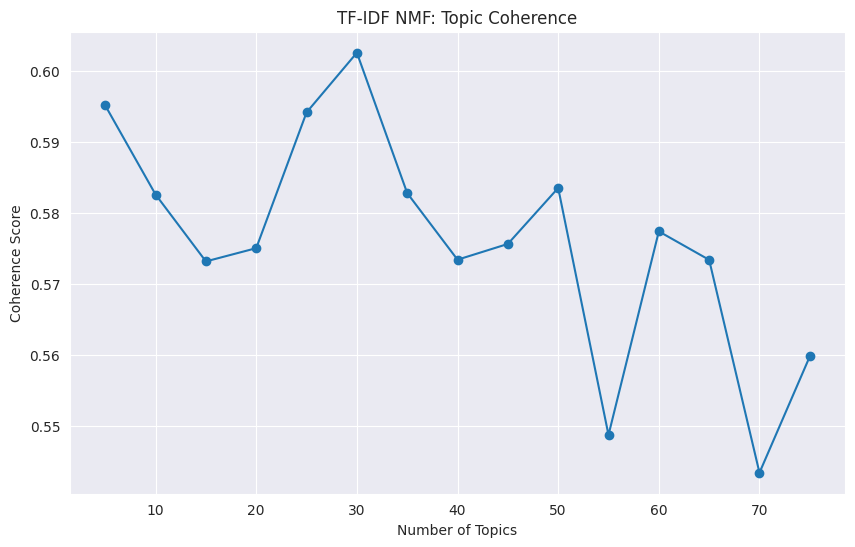

Optimal topics: 30


In [32]:
coherence_scores_tfidf = []
topic_range = range(5, 80, 5)

for n in topic_range:
    print(f"Testing {n} topics...")
    
    nmf_temp = NMF(n_components=n, init='nndsvd', random_state=42, max_iter=500)
  
    nmf_temp.fit(tfidf_matrix)
    
    topics = get_nmf_topics(nmf_temp, feature_names, n_top_words=10)
    cm = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = cm.get_coherence()
    coherence_scores_tfidf.append(coherence)
    print(f"  Coherence: {coherence:.4f}")

# Plot and find optimal
plt.figure(figsize=(10, 6))
plt.plot(topic_range, coherence_scores_tfidf, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('TF-IDF NMF: Topic Coherence')
plt.grid(True)
plt.show()

optimal = list(topic_range)[coherence_scores_tfidf.index(max(coherence_scores_tfidf))]
print(f"Optimal topics: {optimal}")

# Test 30 Topics  

In [33]:
#fit the model 
n_topics_30= 30
nmf_model_30 = NMF(n_components=n_topics_30, init='nndsvd', random_state=42, max_iter=1000)
nmf_topics_30 = nmf_model_30.fit_transform(tfidf_matrix)

In [34]:
# Extract dominant topic for each document
df["topic_num"] = nmf_topics_30.argmax(axis=1)

In [35]:
def display_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[-n_top_words:][::-1]
        top_terms = [feature_names[i] for i in top_indices]
        print(f"Topic {topic_idx}: {', '.join(top_terms)}")

In [36]:
# Display top words per topic
display_topics(nmf_model_30, feature_names, n_top_words=30)

Topic 0: school, dfe, school dfe, school school, leader, trust, free, bill, school leader, school bill, budget, free school, dfe school, parent, new, teacher school, meal, paper, headteacher, improvement, crisis, academy, good, samantha, school report, effective, school meal, ai school, change, cost
Topic 1: poverty, child poverty, child, poverty strategy, government child, strategy, poverty child, government, statistic, family, approach, project child, new approach, local, limit, issue, parent, project, child school, mission, practice accelerator, accelerator, accelerator fund, poverty practice, approach child, cabinet, school staff, fund, additional, action group
Topic 2: education, foundation, new, education system, nuffield, future, manifesto, system, nuffield foundation, event, education report, general election, teacher education, education new, department, general, child education, challenge, election, ai education, fed, education policy, early education, resource, roundtable, e

# Check Topic Stability 

In [37]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def run_nmf(seed):
    model = NMF(
        n_components=30,      # chosen number of topics
        random_state=seed,
        max_iter=3000,
        init='nndsvda'
    )
    W = model.fit_transform(tfidf_matrix)
    H = model.components_
    return H   # topic-word matrix

In [38]:
topic_runs = [run_nmf(seed) for seed in [1, 2, 3, 4, 5]]

In [39]:
def topic_similarity(H1, H2):
    sim_matrix = cosine_similarity(H1, H2)
    return sim_matrix.max(axis=1).mean()  # best match per topic

In [40]:
stabilities = [
    topic_similarity(topic_runs[0], H)
    for H in topic_runs[1:]
]

print("Stability scores:", stabilities)
print("Average stability:", np.mean(stabilities))

Stability scores: [np.float64(0.8843675069051952), np.float64(0.9464546792635694), np.float64(0.9139022268477007), np.float64(0.9200987300793737)]
Average stability: 0.9162057857739597


#### 0.916 means 30 topics remain nearly identical across multiple random seeds

# 📌 Summary of the Topic Modelling Workflow (Updated)

## 1. Preprocessing Pipeline

The text data underwent a structured cleaning process to remove noise and ensure that the extracted topics reflect **meaningful policy themes** rather than stylistic features or irrelevant metadata.

### **Preprocessing steps included:**

- Lowercasing all text  
- Removing URLs, punctuation, numbers, and bracketed content  
- Removing **personal names**, **media-source identifiers**, **country/nationality terms**, and **time-related stopwords**  
- Tokenisation using spaCy  
- Lemmatization  
- Stopword removal  
- Part-of-speech filtering (keeping only **NOUN**, **PROPN**, **ADJ**)  
- Reconstructing cleaned documents  
- TF–IDF vectorisation using:  
  - **bigrams** (`ngram_range = (1, 2)`)  
  - vocabulary limits (`min_df=3`, `max_df=0.85`, `max_features=3000`)  

This pipeline ensured that topics captured genuine **education policy themes** rather than artefacts of writing style or named individuals.

---

## 2. NMF Modelling

NMF was applied to the TF–IDF matrix using:

- `init='nndsvd'`, a non-negative initialisation method that improves convergence on sparse TF–IDF data  
- A range of topic numbers (5–75 in increments of 5)  
- Top terms extracted using a custom topic-word function based on the NMF components matrix  

---

## 3. Topic Coherence Results

Models with different topic numbers were compared using **c_v coherence**, which measures how semantically related the top words within each topic are.

The coherence curve showed a clear peak at:

### ⭐ **30 topics**

indicating that the 30-topic model provides:

- the most semantically meaningful topics  
- good separation between themes  
- optimal interpretability relative to the dataset  

CountVectorizer was removed due to weaker coherence and less interpretable topics.

---

## 4. Topic Stability Analysis

Topic stability was evaluated by fitting several 30-topic NMF models using different random seeds and comparing the topic-word matrices with cosine similarity.

The stability results showed:

### ⭐ **Average stability ≈ 0.91**

A stability score above **0.90** demonstrates excellent reproducibility, meaning the 30-topic structure is robust across different initialisations.

---

## 5. Final Decision: Selected Number of Topics

Based on:

- highest coherence  
- strong stability  
- clearer semantic structure  
- meaningful and interpretable policy-related themes  

the final selected model is:

### 🎯 **30-topic TF–IDF NMF model (with bigrams)**

This model provides the strongest balance of coherence, robustness, and interpretability and is suitable for:

- thematic analysis  
- mapping policy discourse  
- linking topics with Named Entities  
- dashboard and visual outputs  

---

# ✅ Next Steps

With the optimal **30-topic NMF model** selected, the next stage focuses on interpretation, validation, and preparing outputs for analysis and visualisation.

### **1. Extract and Manually Review Topics**

- Examine the top words for each of the 30 topics.  
- Read several sample documents associated with each topic.  
- Assess whether the topics are coherent, meaningful, and policy-relevant.  

### **2. Assign Topic Labels**

- Give each topic a clear, human-readable name based on:  
  - top words  
  - representative documents  
  - policy context  
- Ensure labels reflect **substantive themes**, not artefacts of writing style.  

### **3. Validate Topics Against Original Text**

- Check that topic assignments are consistent with the newsletter content.  
- Confirm that topics align with known policy themes and terminology.  
- Note any overlapping or unclear topics for refinement.  

### **4. Visualise the Topics**

Potential visualisations include:

- Top words per topic (bar charts or word clouds)  
- Topic distribution across documents  
- Topic similarity heatmaps (cosine similarity)  
- Temporal trends (if dates are available)  

### **5. Save Results**

- Save:  
  - the final 30-topic model  
  - topic-word matrix (H)  
  - document-topic matrix (W)  
  - topic labels  
  - coherence and stability outputs  
- Export results for:  
  - dashboards  
  - reporting  
  - downstream policy analysis  

---


# Extract and manually review topics 

In [41]:
topics_30 = get_nmf_topics(nmf_model_30, feature_names, n_top_words=30)

In [42]:
# Convert each topic into a row with topic number + top words as a string
df_topics = pd.DataFrame({
    "Topic_Number": range(1, len(topics_30) + 1),
    "Top_Words": ["; ".join(words) for words in topics_30]
})

df_topics.head()

,Topic_Number,Top_Words
0,1,school; dfe; school dfe; school school; leader...
1,2,poverty; child poverty; child; poverty strateg...
2,3,education; foundation; new; education system; ...
3,4,teacher; school teacher; teacher school; workl...
4,5,people; young people; young; child young; chil...


In [43]:
output_path = "/workspaces/AM1_topic_modelling/data/Interrim/mapping_topics_short.xlsx"
df_topics.to_excel(output_path, index=False)

print("Saved to:", output_path)

Saved to: /workspaces/AM1_topic_modelling/data/Interrim/mapping_topics_short.xlsx


## Note: 
In total, 30 topics were generated using the NMF model. Of these, 25 topics were immediately coherent and straightforward to name based on their top terms and thematic focus. Five topics required deeper interpretation, cross-checking against example words, and iterative refinement to identify an accurate and defensible label. **The five topics that were harder to name were ultimately labelled as School System Reform (Topic 0, reflecting DfE actions, school structures, academies/trusts, bills, funding pressures, and systemic change), Childhood & Youth Policy (Topic 4, centred on children and young people as a policy group, literacy, survey evidence, parliamentary inquiry, and social opportunity), Government & Public Service Reform (Topic 7, capturing government structures, public services, devolution, and civil service reform), Teacher Professionalism (Topic 16, focused on the teaching profession, OECD perspectives, workforce diversity, skills, and system transformation), and Education Funding & Grants (Topic 24, combining school funding pressures with research grants, budgets, programmes, and support for disadvantaged groups).

# Map manually selected topics

In [44]:
topic_names = {
    0:  "school_reform_funding",              # School structures, governance and funding reform
    1:  "child_poverty_inequality",           # Child poverty, family hardship and inequality
    2:  "education_policy_manifestos",        # Education reform agendas and political manifestos
    3:  "teacher_pay_workload_wellbeing",     # Teacher pay, workload and staffing pressures
    4:  "childhood_youth_policy",             # Policies affecting children and young people
    5:  "research_evidence_funding",          # Research policy, evidence use and funding
    6:  "send",                               # Special educational needs and disabilities reform
    7:  "government_public_service_reform",   # Government structures and public service reform
    8:  "artificial_intelligence_edtech",     # AI and digital technology in education
    9:  "childrens_rights",                   # Children’s rights, regulation and advocacy
    10: "education_reports_annual_reviews",   # Annual sector reports and system reviews
    11: "pupil_absence_attainment",           # Attendance trends and attainment gaps
    12: "digital_divide",                     # Inequalities in digital access and inclusion
    13: "universities_knowledge_exchange",    # University engagement and knowledge exchange
    14: "parliamentary_committees_inquiries", # Parliamentary inquiries and evidence sessions
    15: "mental_health_wellbeing",            # Mental health and wellbeing in education
    16: "teacher_professionalism",            # Professional identity and diversity in teaching
    17: "professional_learning_leadership",   # Teacher development and leadership programmes
    18: "public_policy_evidence_use",         # Evidence use and innovation in policymaking
    19: "mobile_phone_policy",                # School mobile phone bans and usage rules
    20: "teacher_training",                   # Initial teacher training and accreditation
    21: "teacher_recruitment_retention",      # Recruitment and retention challenges
    22: "covid19_impact",                     # Education impacts of COVID-19
    23: "school_performance_improvement",     # School performance, inspection and improvement
    24: "education_funding_grants",           # School funding levels and grant programmes
    25: "education_secretary",                # Bridget Phillipson’s education agenda
    26: "curriculum_assessment_reform",       # Curriculum and assessment reforms
    27: "northern_ireland_education",         # Education developments in Northern Ireland
    28: "ofsted_reform",                      # Proposals for reforming Ofsted
    29: "labour_party_education_agenda"       # Labour’s priorities and education plans
}

In [45]:
# Map to final topic names
df["topic_name"] = df["topic_num"].map(topic_names)

df[["topic_num", "topic_name"]].head()

,topic_num,topic_name
0,8,artificial_intelligence_edtech
1,20,teacher_training
2,25,education_secretary
3,12,digital_divide
4,29,labour_party_education_agenda


# Show top documents for different topics


In [46]:
W_30 = nmf_model_30.transform(tfidf_matrix)   # shape: (documents, 30 topics)

In [47]:
topic_cols = [f"topic_{i+1}" for i in range(n_topics_30)]

df_topics = pd.DataFrame(W_30, columns=topic_cols)
df = pd.concat([df.reset_index(drop=True), df_topics], axis=1)

In [48]:
def show_top_docs(topic_name, W, df, n=5, text_col="text"):
    # Find the topic number for the given name
    # Example: "teacher_professionalism" → 16
    reverse_map = {v: k for k, v in topic_names.items()}
    
    if topic_name not in reverse_map:
        print(f"Topic '{topic_name}' not found.")
        return
    
    topic_num = reverse_map[topic_name]
    
    # Sort documents by weight on this topic
    doc_indices = W[:, topic_num].argsort()[::-1][:n]
    
    print(f"\n🔎 Top {n} documents for topic: **{topic_name}** (Topic {topic_num})\n")
    
    for rank, idx in enumerate(doc_indices, start=1):
        print(f"Document {rank} (index {idx}):\n")
        print(df.loc[idx, text_col])
        print("-" * 90)

In [49]:
rows = []

# Convert human topic numbers (1–30) back to NMF indices (0–29)
reverse_map = {v: k-1 for k, v in topic_names.items()}

for topic_name, nmf_index in reverse_map.items():

    # Get top 5 docs for this NMF topic
    doc_indices = W_30[:, nmf_index].argsort()[::-1][:5]

    top_docs = [df.loc[idx, "text"] for idx in doc_indices]

    rows.append({
        "topic_num": nmf_index + 1,   # back to human-readable numbering
        "topic_name": topic_name,
        "top_doc_1": top_docs[0],
        "top_doc_2": top_docs[1],
        "top_doc_3": top_docs[2],
        "top_doc_4": top_docs[3],
        "top_doc_5": top_docs[4],
    })

df_topdocs = pd.DataFrame(rows)

output_path = "/workspaces/AM1_topic_modelling/data/Interrim/top5_docs_per_topic.xlsx"
df_topdocs.to_excel(output_path, index=False)

print("Saved to:", output_path)


Saved to: /workspaces/AM1_topic_modelling/data/Interrim/top5_docs_per_topic.xlsx


# Visualisations 

## *Topic-word bar charts*

In [50]:
def plot_topic_words_named(model, feature_names, topic_num, topic_names, n_top_words=10):
    topic_label = topic_names.get(topic_num, f"Topic {topic_num}")
    topic = model.components_[topic_num]
    
    top_indices = topic.argsort()[-n_top_words:][::-1]
    top_terms = [feature_names[i] for i in top_indices]
    top_weights = topic[top_indices]

    plt.figure(figsize=(10, 5))
    plt.barh(top_terms[::-1], top_weights[::-1], color='seagreen')
    plt.xlabel("Weight")
    plt.title(f"Top {n_top_words} Terms: {topic_label}")
    plt.tight_layout()
    plt.show()

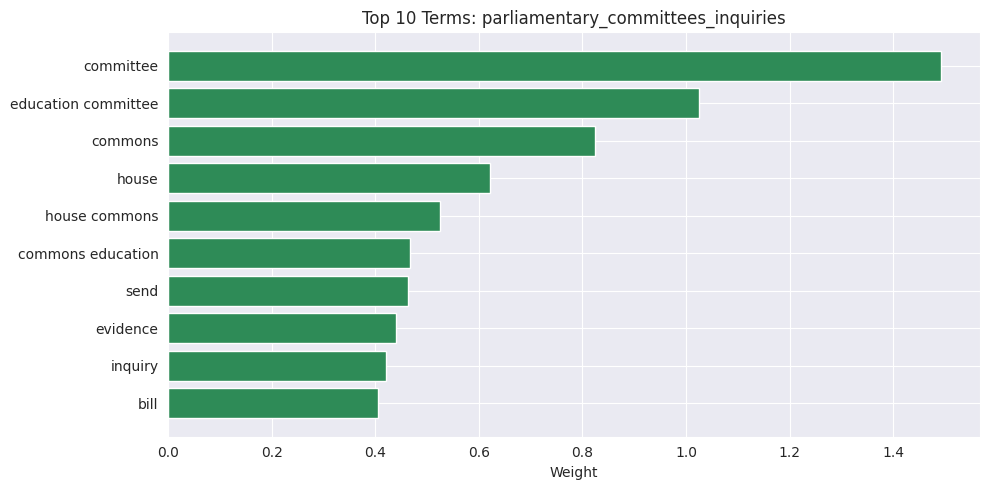

In [51]:
plot_topic_words_named(nmf_model_30, feature_names, 14, topic_names)

## *Topic distribution across corpus*

/tmp/ipykernel_115169/2921664342.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["topic_name"], palette="magma")


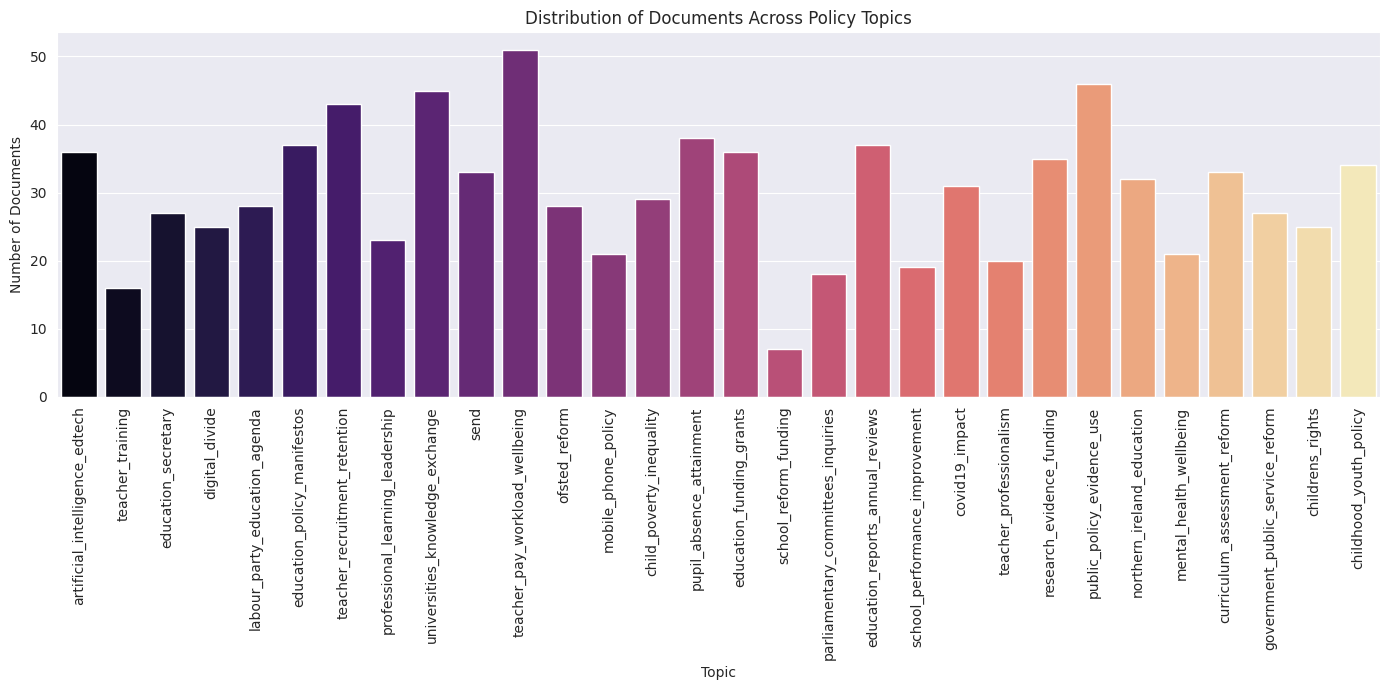

In [52]:
# Topic Distribution across corpus 
plt.figure(figsize=(14, 7))
sns.countplot(x=df["topic_name"], palette="magma")
plt.xlabel("Topic")
plt.ylabel("Number of Documents")
plt.title("Distribution of Documents Across Policy Topics")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

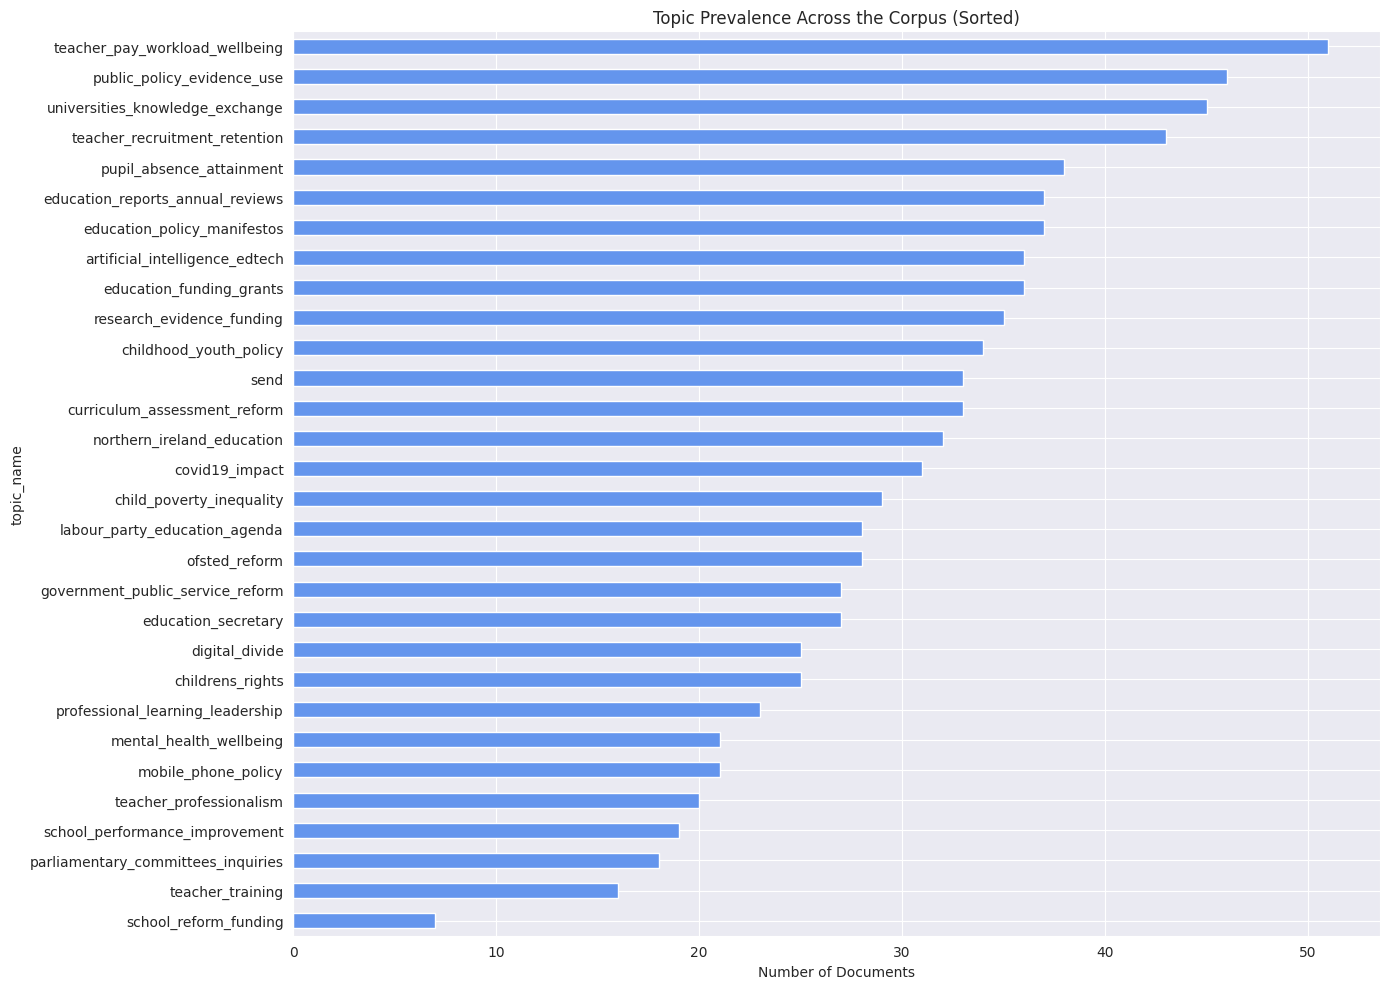

In [53]:
topic_counts_sorted = df["topic_name"].value_counts().sort_values(ascending=True)

plt.figure(figsize=(14, 10))
topic_counts_sorted.plot(kind="barh", color="cornflowerblue")
plt.xlabel("Number of Documents")
plt.title("Topic Prevalence Across the Corpus (Sorted)")
plt.tight_layout()
plt.show()


## *Topic Similarity Heatmap (Cosine Similarity Between Topics)*

In [54]:
# H = topic-word matrix
H = nmf_model_30.components_

# compute topic similarity
topic_sim_matrix = cosine_similarity(H)
topic_sim_matrix.shape


(30, 30)

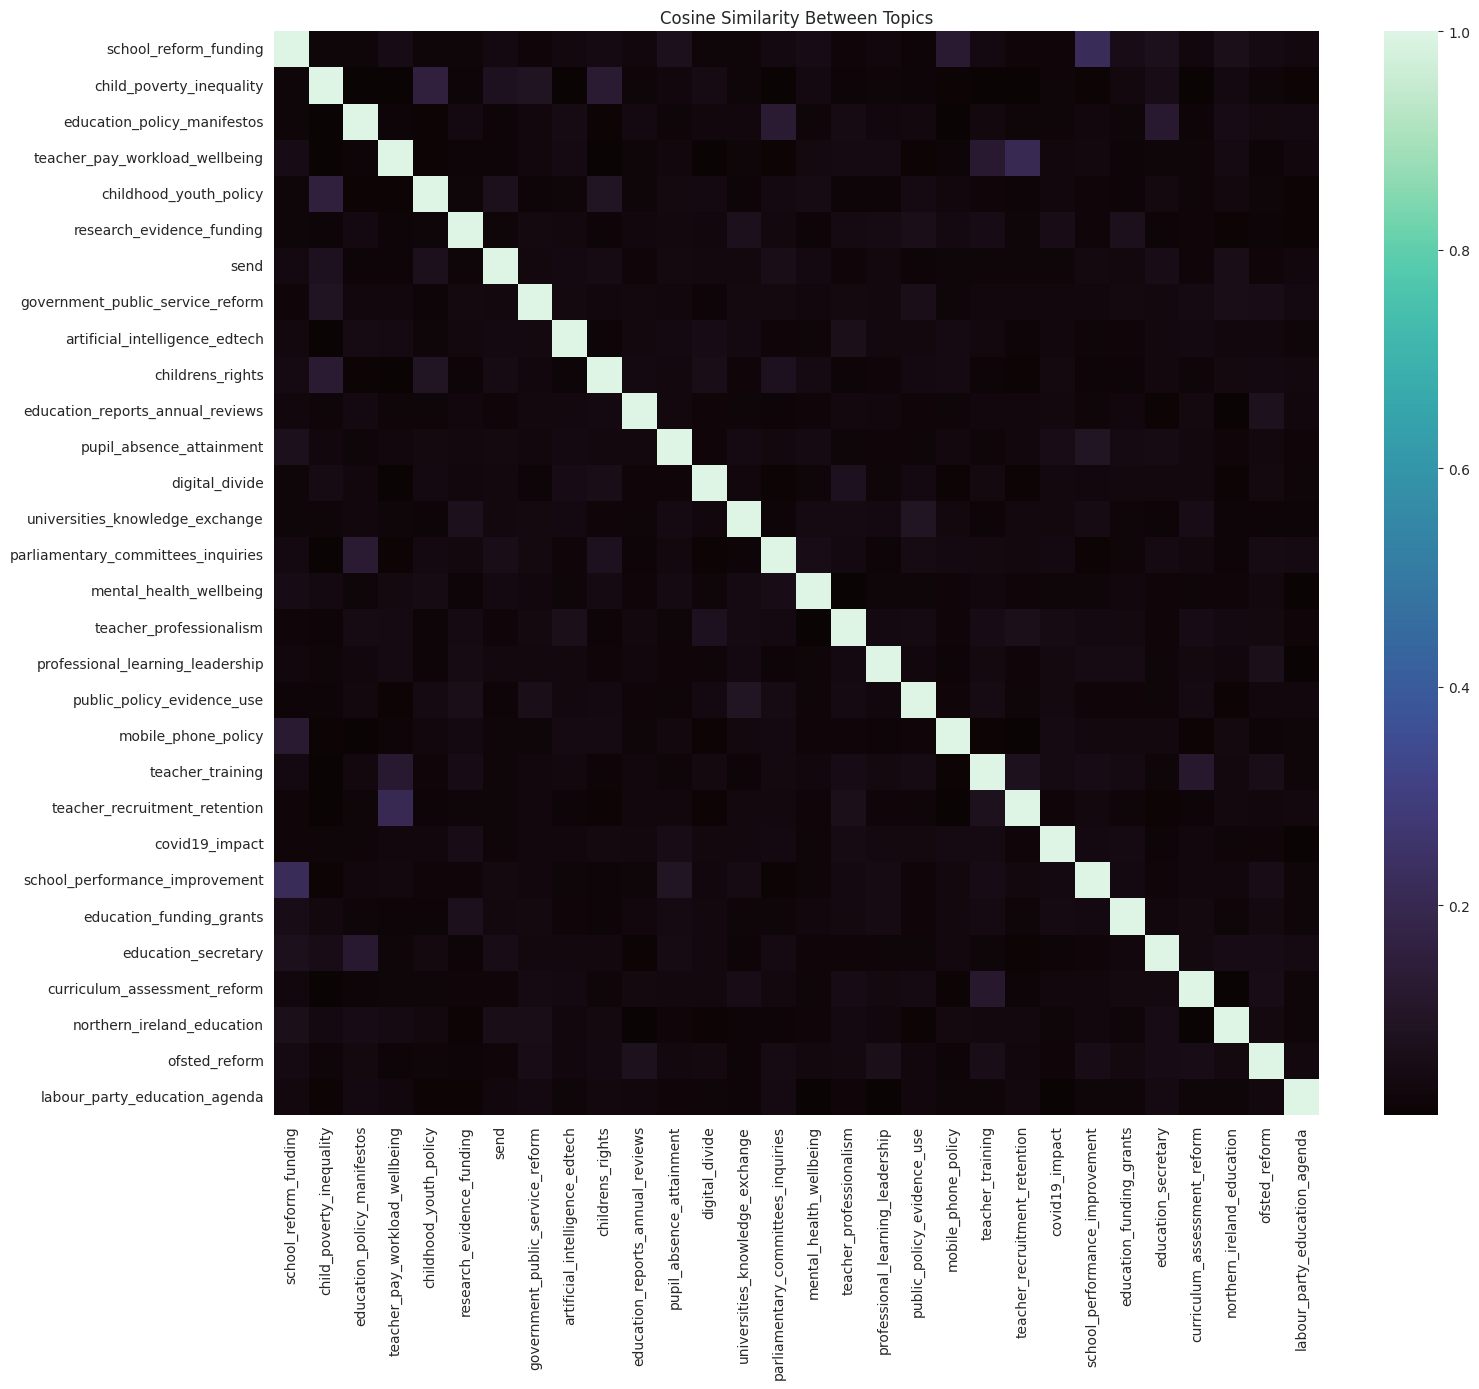

In [55]:
# reorder labels as a list according to topic number order
labels = [topic_names[i] for i in range(len(topic_names))]

plt.figure(figsize=(16, 14))
sns.heatmap(
    topic_sim_matrix,
    cmap="mako",
    xticklabels=labels,
    yticklabels=labels,
    annot=False
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Cosine Similarity Between Topics")
plt.tight_layout()
plt.show()

### Interpretation: The heatmap shows that the 30 NMF topics are highly distinct from one another, with very low cosine similarity across topics, indicating strong separation and minimal thematic overlap.

## *Document-topic heatmap*

In [56]:
# Take a subset to keep the heatmap readable
sample_size = 50
sample_indices = np.random.choice(df.index, sample_size, replace=False)

W_sample = W_30[sample_indices, :]
df_sample = df.loc[sample_indices]

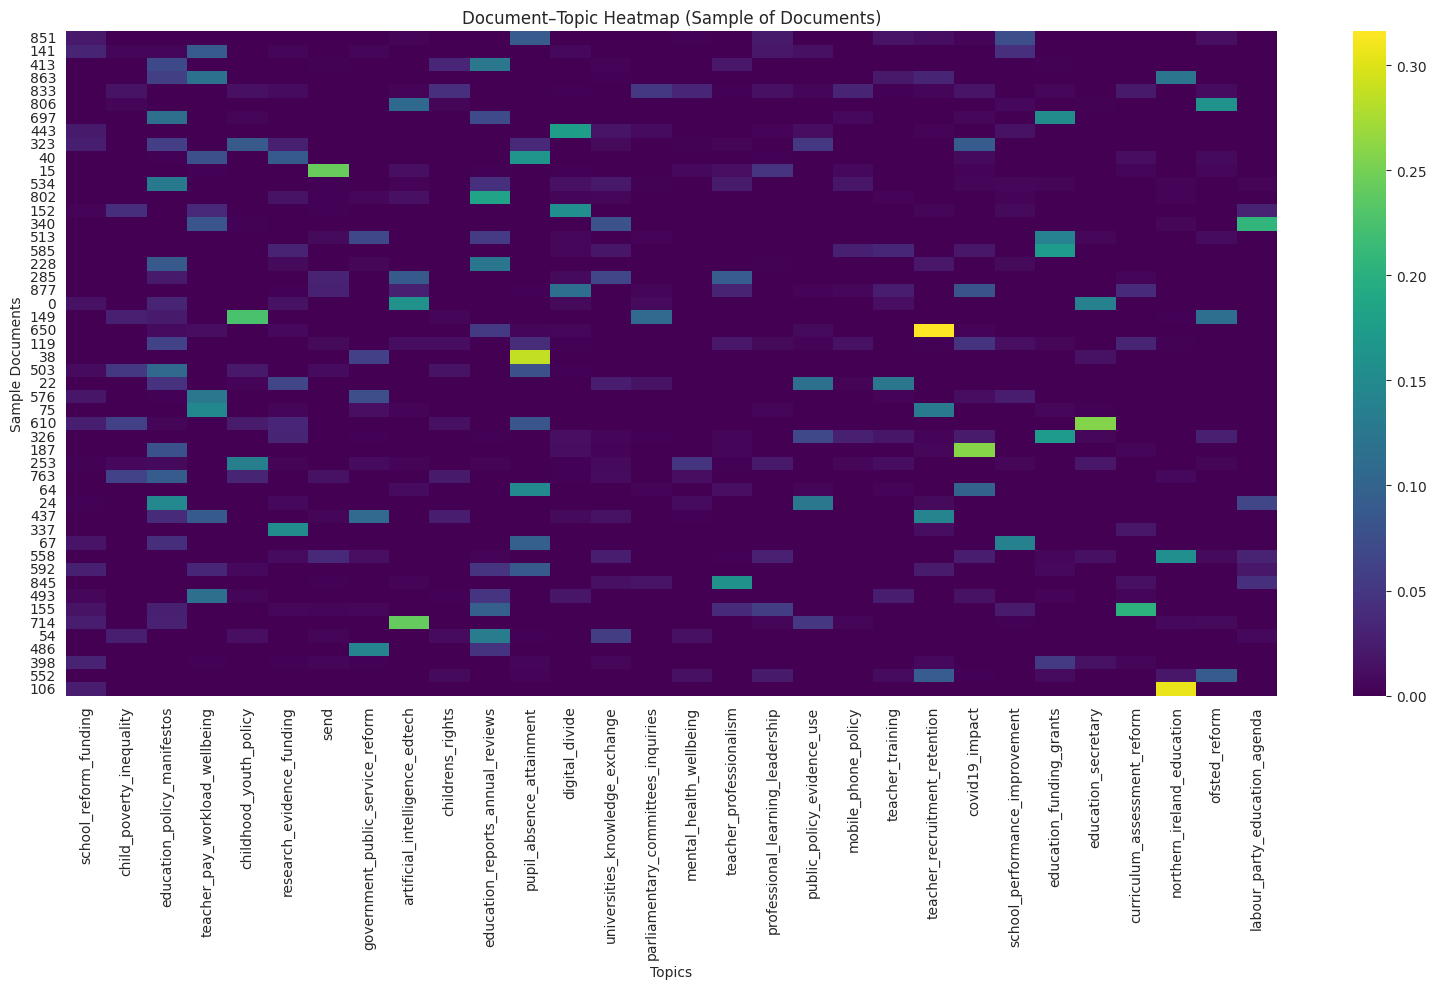

In [57]:
plt.figure(figsize=(16, 10))
sns.heatmap(
    W_sample,
    cmap="viridis",
    xticklabels=[topic_names[i] for i in range(30)],
    yticklabels=df_sample.index,
)
plt.xlabel("Topics")
plt.ylabel("Sample Documents")
plt.title("Document–Topic Heatmap (Sample of Documents)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Interpretation: The document–topic heatmap shows that most documents load strongly onto a single dominant topic, with scattered secondary loadings, indicating that the 30-topic NMF model captures well-defined policy themes with occasional overlap across related topics.

## *Topic Trends Over Time (Month & Year)*

In [85]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [86]:
W_30 = nmf_model_30.transform(tfidf_matrix)

In [87]:
for i, name in enumerate(topic_names.values()):
    df[name] = W_30[:, i]

In [88]:
# Get list of topic names
topic_name_list = list(topic_names.values())

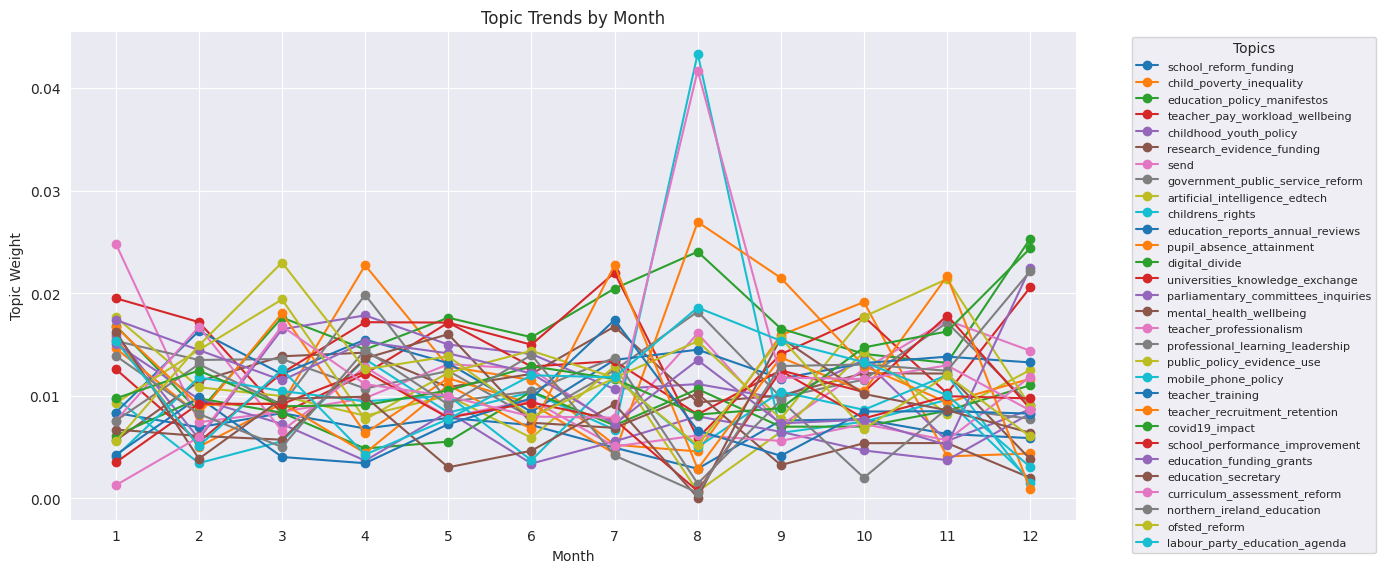

In [90]:
# BY MONTH
monthly_avg = df.groupby('month')[topic_name_list].mean()
monthly_avg.plot(figsize=(14, 6), marker='o')
plt.xlabel('Month')
plt.ylabel('Topic Weight')
plt.title('Topic Trends by Month')
plt.xticks(range(1, 13))
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), fontsize=8)
plt.tight_layout()
plt.show()


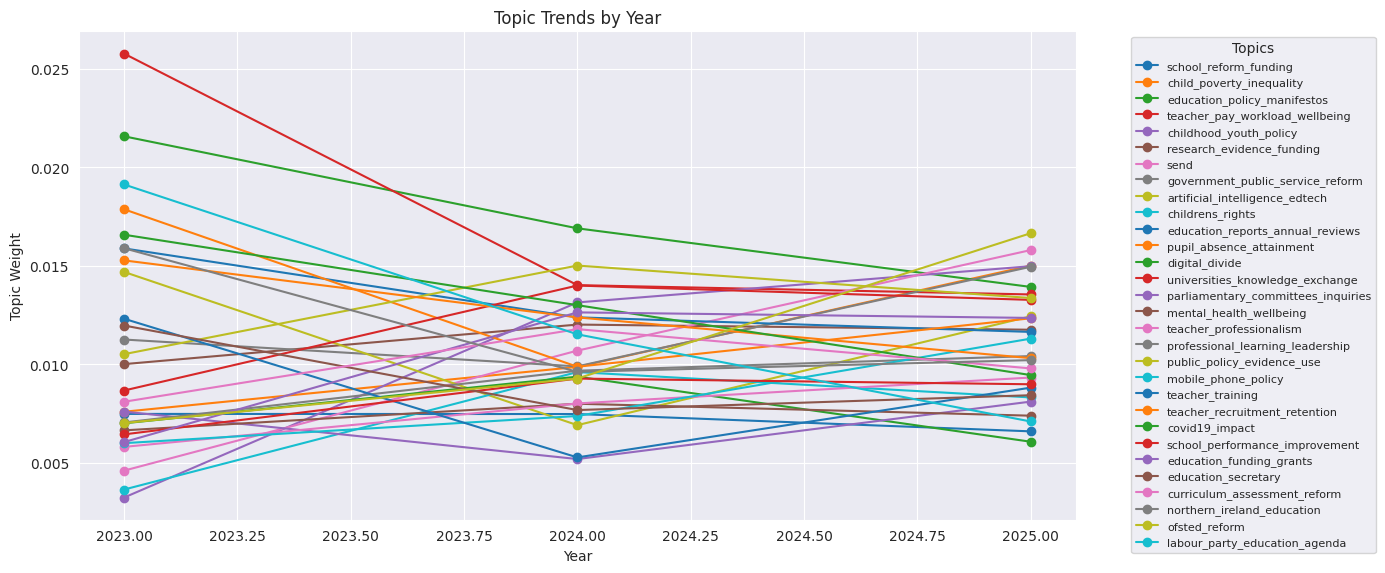

In [91]:
# BY YEAR
yearly_avg = df.groupby('year')[topic_name_list].mean()
yearly_avg.plot(figsize=(14, 6), marker='o')
plt.xlabel('Year')
plt.ylabel('Topic Weight')
plt.title('Topic Trends by Year')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), fontsize=8)
plt.tight_layout()
plt.show()


# Final Steps and Next Actions

This notebook provides an exploratory end-to-end workflow for topic modelling using a 30-topic NMF model. The analysis covered preprocessing, TF–IDF vectorisation, model fitting, coherence and stability evaluation, topic interpretation, and initial visualisation. The aim at this stage was to understand the thematic structure of the corpus and assess whether NMF provides coherent, interpretable topics.

## Next Steps

1. **Test on unseen data**  
   I will apply the trained NMF model to new or unseen documents to check whether the topic structure generalises and to evaluate model behaviour outside the training set.

2. **Compare with other models**  
   I will run additional topic models (e.g., LDA, BERTopic, Top2Vec) to compare coherence, interpretability, and performance. This will help determine whether NMF is the most suitable approach for this dataset.

3. **Refactor into modular code**  
   This notebook is intentionally exploratory. In the next phase, I will refactor the workflow into modular scripts for preprocessing, modelling, evaluation, and visualisation to improve clarity, maintainability, and reproducibility.

This completes the exploratory phase of the topic modelling workflow.
